In [1]:
%%bash
pip install h2o
wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
--2025-06-26 10:11:29--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.198.78
Connecting to drive.google.com (drive.google.com)|142.250.198.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-26 10:11:30--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.204.33
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.204.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

     0K .......... .......... .......... .....

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib.font_manager import fontManager
import matplotlib.pyplot as plt
import pickle
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
import math
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')
warnings.filterwarnings('ignore')

In [33]:
def preproc_to_raw_data(data_preproc_):
  # onehot 後的data 轉回raw data
  df_ = pd.DataFrame()
  for c in data_preproc_.columns:
    if c in X_features:
      dt = label_enc[c].inverse_transform(data_preproc_[c])
      df_[c] = dt
    else:
      df_[c] = data_preproc_[c]
  return df_

In [6]:
# 預先在雲端硬碟中上傳 new_data.csv
injection_data_path = '../data/16539338267026_new_data.csv'

# 輸出檔案至雲端硬碟
scalar_path = '../data/scalar-20220803-factor.pickle'
save_model_path = '../model/h2o_injection_model-20220803-factor.model'

In [7]:
data = pd.read_csv(injection_data_path)

In [8]:
y_feature = '重量'
X_features = ['射出一速_最高壓力','射出一速_速度','射出二速_最高壓力','射出二速_速度','儲料位置','一段保壓_速度']
select_features = data.columns
data = data[X_features+[y_feature]]

print(data.shape)
print(data.head(5))

(4886, 7)
   射出一速_最高壓力  射出一速_速度  射出二速_最高壓力  射出二速_速度   儲料位置  一段保壓_速度     重量
0      100.4    64.31      120.7    50.40  93.00     0.32  124.6
1      107.3    70.76      120.4    42.14  93.03     0.29  124.6
2      108.6    72.48      121.4    44.84  92.99     0.48  124.6
3      108.0    71.89      121.5    46.12  93.04     0.41  124.6
4      107.0    71.15      120.4    49.30  93.09     0.30  124.6


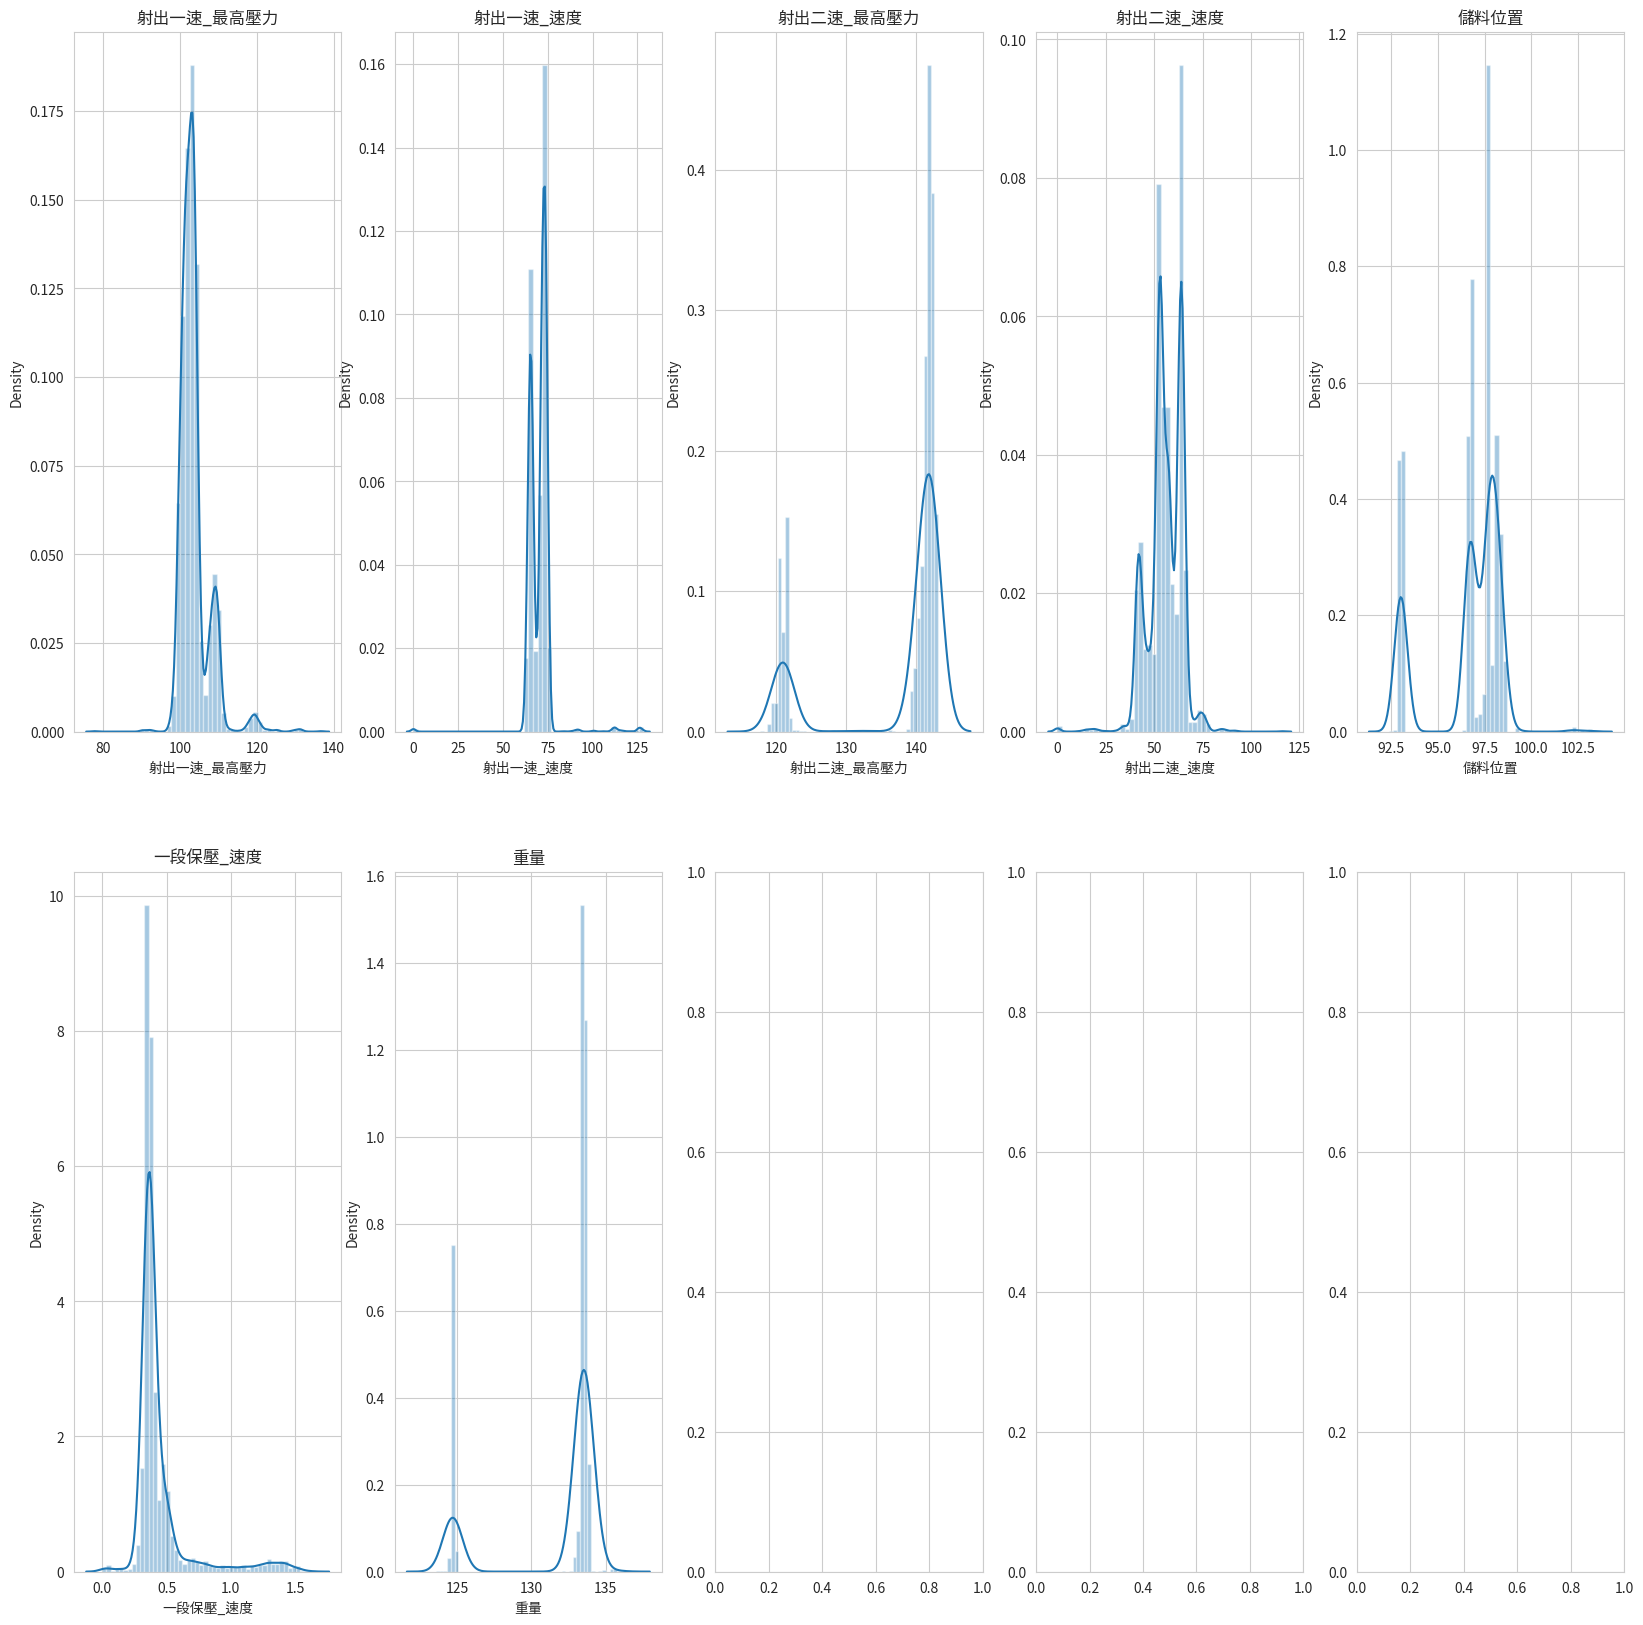

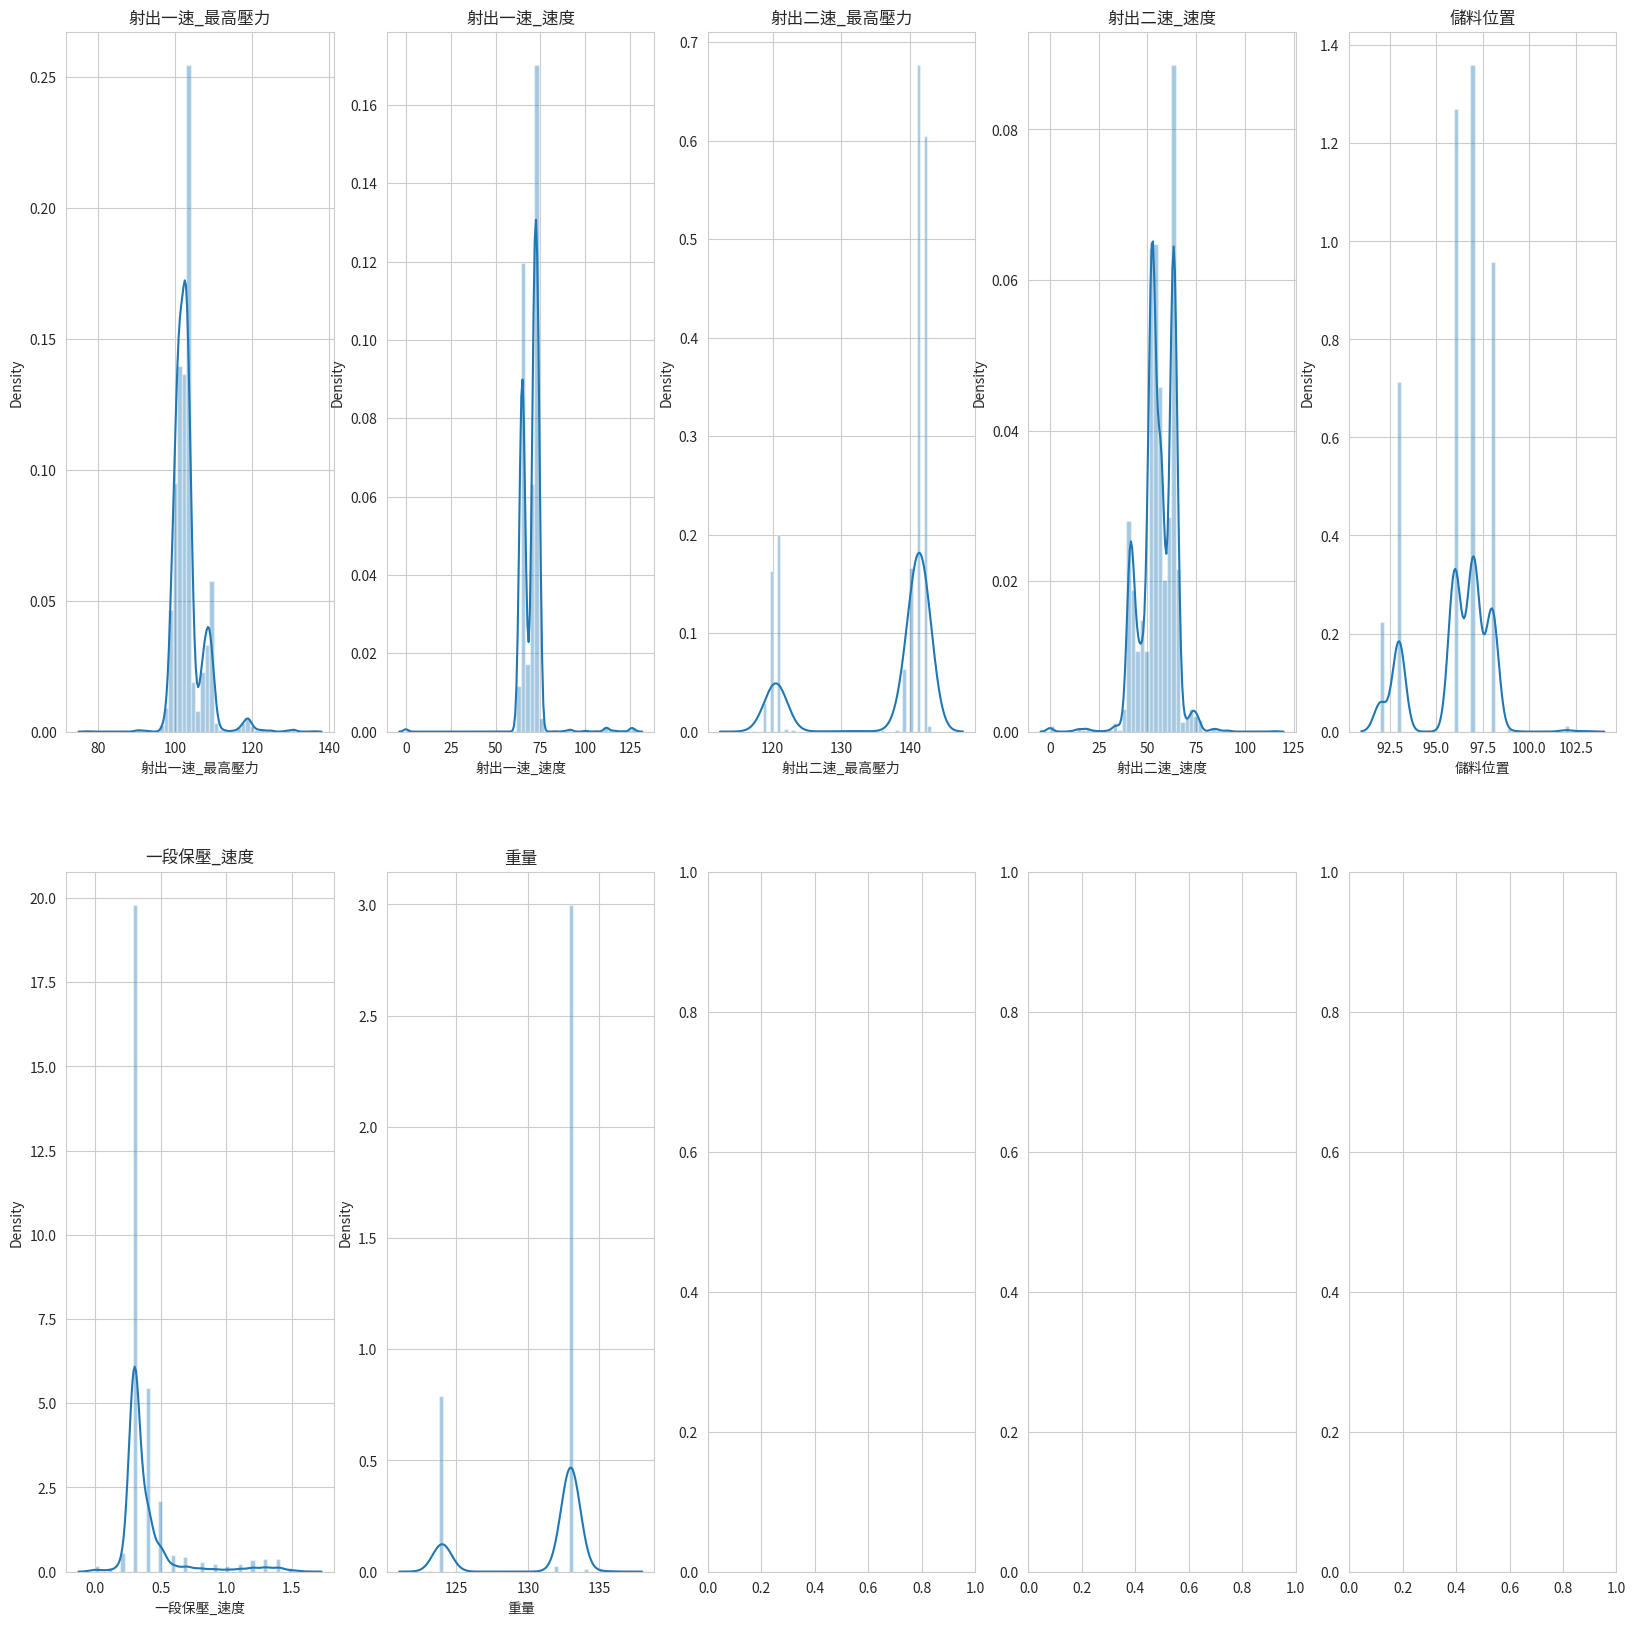

In [9]:
fig, axes = plt.subplots(ncols=5, nrows=2,figsize=(20,20))
for i, ax in zip(data.columns, axes.flat):
    sns.distplot(data[i], hist=True, ax=ax).set(title=i)
plt.show()

from scipy import stats
data_ = data.copy().dropna()#[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
fig, axes = plt.subplots(ncols=5, nrows=2,figsize=(20,20))
for i, ax in zip(data_.columns, axes.flat):
    if i == '一段保壓_速度':
      data_[i] = data_[i].apply(lambda v: math.floor(v * 10) / 10.0)
    else:
      data_[i] = data_[i].apply(lambda v: math.floor(v))
    sns.distplot(data_[i], hist=True, ax=ax).set(title=i)
plt.show()


In [10]:
# 類別變數轉換
label_enc = {}
for c in X_features:
  enc = LabelEncoder()
  data_[c] = enc.fit_transform(data_[c])
  label_enc[c] = enc

In [11]:
data_preproc = pd.DataFrame()
one_hot_enc = {}

for c in X_features:
  one_hot = OneHotEncoder()
  dt = pd.DataFrame(one_hot.fit_transform(data_[[c]]).toarray())
  dt = dt.add_prefix('%s_'%c)
  dt = dt.astype(int)
  data_preproc = pd.concat([data_preproc.reset_index(drop=True),dt],axis=1)
  one_hot_enc[c] = one_hot
data_preproc = data_preproc.astype(int)


#切分訓練資料與測試資料
train_data, test_data = train_test_split(data_, test_size=0.2)

In [12]:
scalar = {}
scalar['label'] = label_enc
scalar['one_hot'] = one_hot_enc
pickle.dump(scalar, open(scalar_path, 'wb'))

In [13]:
pickle.dump(label_enc, open('label_enc-20220803.pickle', 'wb'))
pickle.dump(one_hot_enc, open('one_hot_enc-20220803.pickle', 'wb'))

In [14]:
# 將資料load 進h2o
h2o.init()
train_df = h2o.H2OFrame(train_data)
test_df = h2o.H2OFrame(test_data)
x = X_features
y = y_feature

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.23" 2024-04-16; OpenJDK Runtime Environment Homebrew (build 11.0.23+0); OpenJDK 64-Bit Server VM Homebrew (build 11.0.23+0, mixed mode)
  Starting server from /Users/chris_lo/PycharmProjects/FactoryRL/.venv/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/n0/h0y2mn7n655844sg5fmgh4gwm203r_/T/tmpd6gyjlwv
  JVM stdout: /var/folders/n0/h0y2mn7n655844sg5fmgh4gwm203r_/T/tmpd6gyjlwv/h2o_chris_lo_started_from_python.out
  JVM stderr: /var/folders/n0/h0y2mn7n655844sg5fmgh4gwm203r_/T/tmpd6gyjlwv/h2o_chris_lo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Taipei
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,2 months and 29 days
H2O_cluster_name:,H2O_from_python_chris_lo_w0o0zk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [16]:
for c in x:
  train_df[c] = train_df[c].asfactor()
  test_df[c] = test_df[c].asfactor()

In [17]:
model = H2OAutoML(max_models=20, seed=1,nfolds=5,stopping_metric='MSE',sort_metric='MSE',include_algos=['XGBoost','GLM','DRF','DeepLearning','StackedEnsemble'])
model.train(x=x, y=y, training_frame=train_df)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),11/20
# XGBoost base models (used / total),8/10
# GLM base models (used / total),1/1
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),1/7
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [19]:
print(model.leaderboard)

model_id                                                       mse      rmse        mae        rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20250626_101532     0.013851   0.11769   0.0330382  0.000884902                 0.013851
StackedEnsemble_BestOfFamily_1_AutoML_1_20250626_101532  0.0157014  0.125305  0.035384   0.000941788                 0.0157014
XGBoost_1_AutoML_1_20250626_101532                       0.0159323  0.126223  0.0463076  0.000953561                 0.0159323
XGBoost_3_AutoML_1_20250626_101532                       0.0162542  0.127492  0.0314474  0.000963381                 0.0162542
XGBoost_grid_1_AutoML_1_20250626_101532_model_3          0.0166413  0.129001  0.0308264  0.000960593                 0.0166413
XGBoost_grid_1_AutoML_1_20250626_101532_model_1          0.0189534  0.137671  0.0434465  0.00104301                  0.0189534
XGBoost_grid_1_AutoML_1_20250626_101532_model_2          0.019911   0.141106  0.0339579  0.00107559             

In [22]:
best_model = model.leader

train_pred = best_model.predict(train_df)
train_pred = train_pred.as_data_frame()

test_pred = best_model.predict(test_df)
test_pred = test_pred.as_data_frame()

print('Train MSE :',mean_squared_error(train_data[y_feature],train_pred['predict']))
print('Test MSE :',mean_squared_error(test_data[y_feature],test_pred['predict']))

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Train MSE : 0.0047033879869827514
Test MSE : 0.009716402873257814


In [23]:
h2o.save_model(model=best_model, path=save_model_path, force=True)

'/Users/chris_lo/PycharmProjects/FactoryRL/model/h2o_injection_model-20220803-factor.model/StackedEnsemble_AllModels_1_AutoML_1_20250626_101532'

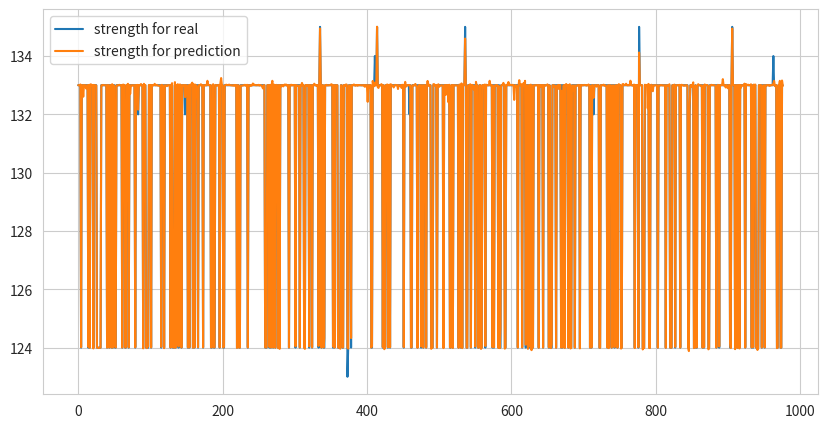

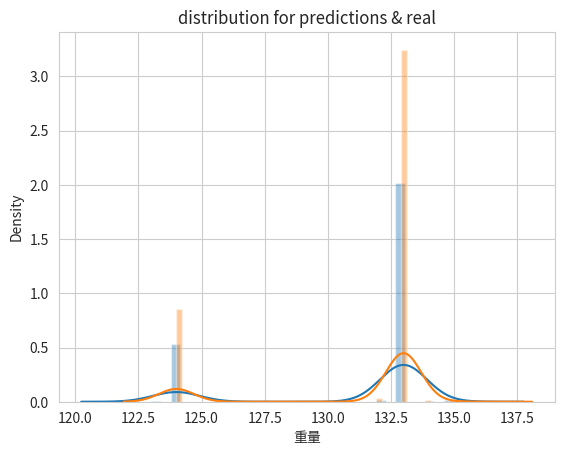

In [29]:
# test data predict vs real strength
test_data = test_data.reset_index(drop=True)
plt.figure(figsize=(10,5))
plt.plot(test_data[y_feature],label='strength for real')
plt.plot(test_pred,label= 'strength for prediction')
plt.legend()
plt.show()
sns.distplot(test_data[y_feature])
sns.distplot(train_data[y_feature])
plt.title("distribution for predictions & real")
plt.show()


In [37]:
## 預測 ##
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,25 mins 55 secs
H2O_cluster_timezone:,Asia/Taipei
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,2 months and 29 days
H2O_cluster_name:,H2O_from_python_chris_lo_w0o0zk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.981 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [39]:
save_model_path =  '../model/h2o_injection_model-20220803-factor.model/StackedEnsemble_AllModels_1_AutoML_1_20250626_101532'
scalar_path = '../data/scalar-20220803-factor.pickle'
with open(scalar_path, 'rb') as f:
    label_enc = pickle.load(f)['label']
best_model = h2o.load_model(save_model_path)

y_feature = '重量'
X_features = ['射出一速_最高壓力','射出一速_速度','射出二速_最高壓力','射出二速_速度','儲料位置','一段保壓_速度']

In [41]:
df = {'射出一速_最高壓力':[77],
 '射出一速_速度':[61],
 '射出二速_最高壓力':[120],
 '射出二速_速度':[68],
 '一段保壓_平均壓力':[108],
 '一段保壓_速度':[0.1],
 '儲料位置':[93]}
def predict_from_df(df):
  raw_data = pd.DataFrame.from_dict(df)
  for c in X_features:
    raw_data[c] = label_enc[c].transform(raw_data[[c]])

  data = h2o.H2OFrame(raw_data)

  raw_data['predict'] = best_model.predict(data)['predict'].as_data_frame()
  return preproc_to_raw_data(raw_data)

def preproc_to_raw_data(data_preproc_):
  # onehot 後的data 轉回raw data
  df_ = pd.DataFrame()
  for c in data_preproc_.columns:
    if c in X_features:
      dt = label_enc[c].inverse_transform(data_preproc_[c])
      df_[c] = dt
    else:
      df_[c] = data_preproc_[c]
  return df_

In [35]:
predict_from_df(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,射出一速_最高壓力,射出一速_速度,射出二速_最高壓力,射出二速_速度,一段保壓_平均壓力,一段保壓_速度,儲料位置,predict
0,77,61,120,68,108,0.1,93,124.261341
